<a href="https://colab.research.google.com/github/vTheWise/speech_language_impairment_detection/blob/main/PhoneticClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google drive (optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
#!unzip '/content/drive/MyDrive/MSAI/Practicum.zip'

# Import packages

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch import nn
from torch.nn import init

# Read data

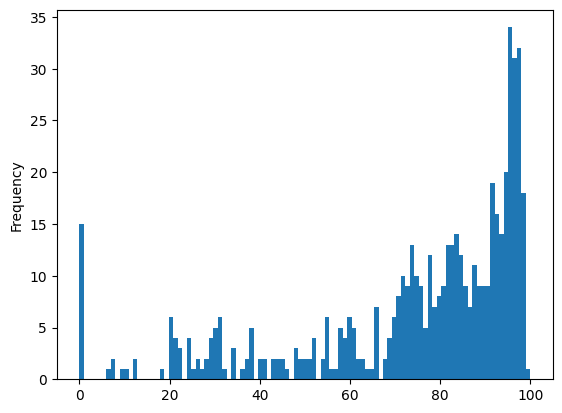

In [ ]:
excel_file_path = '/content/drive/MyDrive/MSAI/Practicum/darcy_db_sh.xlsx'

df = pd.read_excel(excel_file_path)

df['word_asr_score'].plot.hist(bins = 101)

plt.show()

In [ ]:
url_list = df['audio_file_path'].tolist()
id_list = df['exemplar_id'].tolist()
label_list = df['word_label'].tolist()

with open('/content/drive/MyDrive/MSAI/Practicum/darcy_scores.txt', 'w') as f:
    for item in label_list:
        f.write("%s\n" % item)

In [ ]:
if len(os.listdir('/content/drive/MyDrive/MSAI/Practicum/data/pass/')) == 0:      
  for i in range(len(url_list)):
    #print(i)

    label = label_list[i]

    url = url_list[i]

    if label == "TA":
      output_file = "/content/drive/MyDrive/MSAI/Practicum/data/pass/darcy_" + str(id_list[i]) + ".wav"
      subprocess.run(["curl", "-o", output_file, url])

    if label == "BTW":
      output_file = "/content/drive/MyDrive/MSAI/Practicum/data/fail/darcy_" + str(id_list[i]) + ".wav"
      subprocess.run(["curl", "-o", output_file, url])
else:
  print("Files already here")


In [ ]:
class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------

  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)


  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [ ]:
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [ ]:
pass_dir = '/content/drive/MyDrive/MSAI/Practicum/data/pass/'
fail_dir = '/content/drive/MyDrive/MSAI/Practicum/data/fail/'


pass_list = os.listdir(pass_dir)
pass_list = [pass_dir + s for s in pass_list]


fail_list = os.listdir(fail_dir)
fail_list = [fail_dir + s for s in fail_list]

classID = [1] * len(pass_list)
classID = classID + [0] * len(fail_list)

relative_path = pass_list + fail_list

data = {'relative_path': relative_path, 'classID': classID}

# create a DataFrame from the dictionary
df = pd.DataFrame(data)

# print the DataFrame
print(df)


                                         relative_path  classID
0    /content/drive/MyDrive/MSAI/Practicum/data/pas...        1
1    /content/drive/MyDrive/MSAI/Practicum/data/pas...        1
2    /content/drive/MyDrive/MSAI/Practicum/data/pas...        1
3    /content/drive/MyDrive/MSAI/Practicum/data/pas...        1
4    /content/drive/MyDrive/MSAI/Practicum/data/pas...        1
..                                                 ...      ...
534  /content/drive/MyDrive/MSAI/Practicum/data/fai...        0
535  /content/drive/MyDrive/MSAI/Practicum/data/fai...        0
536  /content/drive/MyDrive/MSAI/Practicum/data/fai...        0
537  /content/drive/MyDrive/MSAI/Practicum/data/fai...        0
538  /content/drive/MyDrive/MSAI/Practicum/data/fai...        0

[539 rows x 2 columns]


# Split data into training and test file

In [ ]:
myds = SoundDS(df, '')

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=True)

# CNN based classifier

In [ ]:
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [ ]:
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device

model

AudioClassifier(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=10, bias=True)
  (conv): Sequential(
    (0): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, mome

# Model training

In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  


In [ ]:
num_epochs=35   # Just for demo, adjust this higher.
training(model, train_dl, num_epochs)

Epoch: 0, Loss: 2.28, Accuracy: 0.12
Epoch: 1, Loss: 2.26, Accuracy: 0.23
Epoch: 2, Loss: 2.22, Accuracy: 0.33
Epoch: 3, Loss: 2.19, Accuracy: 0.44
Epoch: 4, Loss: 2.11, Accuracy: 0.52
Epoch: 5, Loss: 1.97, Accuracy: 0.54
Epoch: 6, Loss: 1.74, Accuracy: 0.55
Epoch: 7, Loss: 1.41, Accuracy: 0.56
Epoch: 8, Loss: 1.09, Accuracy: 0.56
Epoch: 9, Loss: 0.89, Accuracy: 0.53
Epoch: 10, Loss: 0.79, Accuracy: 0.57
Epoch: 11, Loss: 0.74, Accuracy: 0.58
Epoch: 12, Loss: 0.73, Accuracy: 0.57
Epoch: 13, Loss: 0.69, Accuracy: 0.62
Epoch: 14, Loss: 0.68, Accuracy: 0.62
Epoch: 15, Loss: 0.69, Accuracy: 0.60
Epoch: 16, Loss: 0.67, Accuracy: 0.63
Epoch: 17, Loss: 0.68, Accuracy: 0.63
Epoch: 18, Loss: 0.67, Accuracy: 0.64
Epoch: 19, Loss: 0.65, Accuracy: 0.63
Epoch: 20, Loss: 0.66, Accuracy: 0.62
Epoch: 21, Loss: 0.65, Accuracy: 0.65
Epoch: 22, Loss: 0.65, Accuracy: 0.66
Epoch: 23, Loss: 0.64, Accuracy: 0.64
Epoch: 24, Loss: 0.64, Accuracy: 0.63
Epoch: 25, Loss: 0.63, Accuracy: 0.68
Epoch: 26, Loss: 0.62,

# Model evaluation over validation set

In [ ]:
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(model, val_dl)

Accuracy: 0.60, Total items: 108


# Display spectrogram

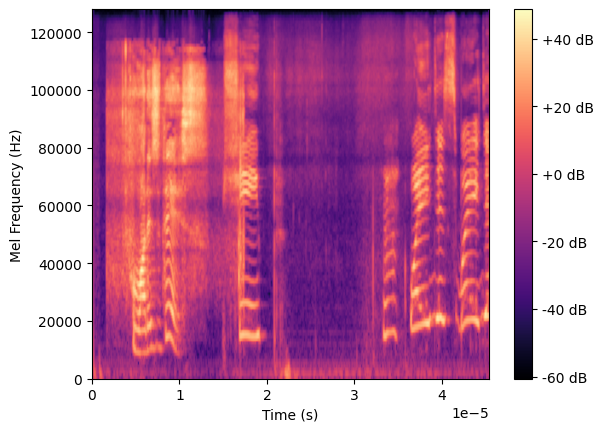

In [ ]:
#t = open("/content/drive/MyDrive/MSAI/Practicum/data/fail/darcy_14650.wav")
filename = "/content/drive/MyDrive/MSAI/Practicum/data/pass/darcy_13732.wav"
waveform, sample_rate = torchaudio.load(filename)

# Compute the mel spectrogram
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate, n_fft=2048, hop_length=512, n_mels=128
)(waveform)

# Convert to decibels
mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

# Average over the channels
mel_spectrogram = mel_spectrogram.mean(dim=0)

# Calculate the duration of the audio file in seconds
duration = len(waveform) / sample_rate

# Calculate the duration of each frame in seconds
frame_duration = mel_spectrogram.shape[1] * 512 / sample_rate

# Create a list of time values for each frame
times = [frame_duration * i for i in range(mel_spectrogram.shape[1])]

# Display the mel spectrogram with time on the x-axis
plt.imshow(mel_spectrogram.numpy(), cmap="magma", origin="lower", aspect="auto", extent=[0, duration, 0, 128*1000])
plt.xlabel("Time (s)")
plt.ylabel("Mel Frequency (Hz)")
plt.colorbar(format="%+2.0f dB")
plt.show()


# Play audio sample

In [ ]:
from IPython.display import Audio

# Play the audio file
Audio(filename)

In [ ]:

for dir in [pass_dir,fail_dir]:
  for filename in os.listdir(dir):
      # check if the file has the extension .txt
      if filename.endswith('.wav'):
          # construct the full file path
          file_path = os.path.join(dir, filename)
          # delete the file
          os.remove(file_path)